<a href="https://colab.research.google.com/github/Haffizuddin7899/-Capstone-Project--Fungal_Disease_Detection_In_Plants_Using_Leaf_Images-/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive and load data
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Define data directory path
data_dir = '/content/gdrive/MyDrive/Capstone Project/DATA/Color'


In [3]:
# Step 2: Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom into images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill missing pixels using the nearest pixel
)


In [5]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 22244 images belonging to 22 classes.


In [6]:
# Step 3: Manual Data Splitting
import os
import shutil

In [7]:
# Create train, test, and validation directories
split_dir = '/content/gdrive/MyDrive/Capstone Project/DATA/data_split/'
os.makedirs(split_dir + 'train', exist_ok=True)
os.makedirs(split_dir + 'test', exist_ok=True)
os.makedirs(split_dir + 'val', exist_ok=True)

In [8]:
# Define the percentage split
train_split = 0.7
test_split = 0.2
val_split = 0.1

In [9]:
# Iterate through the original data directory and move images to the split directories
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    # Create corresponding directories in the split path
    os.makedirs(os.path.join(split_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'test', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'val', class_name), exist_ok=True)

    # List all images in the class directory
    class_images = os.listdir(class_path)
    num_images = len(class_images)

    # Calculate split indices
    train_end = int(train_split * num_images)
    test_end = train_end + int(test_split * num_images)

    # Move images to the appropriate split directory
    for i, image_name in enumerate(class_images):
        image_path = os.path.join(class_path, image_name)
        if i < train_end:
            split_path = os.path.join(split_dir, 'train', class_name)
        elif i < test_end:
            split_path = os.path.join(split_dir, 'test', class_name)
        else:
            split_path = os.path.join(split_dir, 'val', class_name)
        shutil.copy(image_path, os.path.join(split_path, image_name))


In [10]:
# Define new data directories for train, test, and validation

train_data_dir = os.path.join(split_dir, 'train')
test_data_dir = os.path.join(split_dir, 'test')
val_data_dir = os.path.join(split_dir, 'val')

In [11]:
# Data augmentation and preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for validation data
)

# Load and augment validation data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for validation data
)

Found 2240 images belonging to 22 classes.


In [12]:
# Data augmentation and preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for test data
)

# Load and augment test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 4442 images belonging to 22 classes.


In [13]:
# Step 4: Load VGG16 pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [14]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 4s 0us/step


In [15]:
# Create a new model with custom top layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')  # 4 classes (Apple Scab, Black Rot, Apple Rust, Apple Healthy)
])

In [16]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Step 5: Train the model
from tensorflow.keras.callbacks import TensorBoard

In [19]:
# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs')


In [21]:
# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[tensorboard]
)

Epoch 1/10
696/696 [==============================] - 380s 545ms/step - loss: 1.0427 - accuracy: 0.6321 - val_loss: 0.5382 - val_accuracy: 0.7991
Epoch 2/10
696/696 [==============================] - 381s 547ms/step - loss: 0.9703 - accuracy: 0.6560 - val_loss: 0.4021 - val_accuracy: 0.8647
Epoch 3/10
696/696 [==============================] - 379s 544ms/step - loss: 0.9154 - accuracy: 0.6724 - val_loss: 0.4167 - val_accuracy: 0.8482
Epoch 4/10
696/696 [==============================] - 378s 542ms/step - loss: 0.8932 - accuracy: 0.6825 - val_loss: 0.4508 - val_accuracy: 0.8125
Epoch 5/10
696/696 [==============================] - 378s 544ms/step - loss: 0.8585 - accuracy: 0.6974 - val_loss: 0.3637 - val_accuracy: 0.8696
Epoch 6/10
696/696 [==============================] - 379s 545ms/step - loss: 0.8286 - accuracy: 0.7055 - val_loss: 0.3168 - val_accuracy: 0.8964
Epoch 7/10
696/696 [==============================] - 384s 552ms/step - loss: 0.8041 - accuracy: 0.7127 - val_loss: 0.3151 -

In [37]:
model.save('/content/gdrive/MyDrive/Capstone Project/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Step 6: Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


139/139 [==============================] - 24s 169ms/step - loss: 0.3501 - accuracy: 0.8735
Test accuracy: 87.35%


In [24]:
# Generate predictions
predictions = model.predict(test_generator)  # Use test_generator here
predicted_labels = np.argmax(predictions, axis=1)


139/139 [==============================] - 19s 134ms/step


In [25]:
# True labels
true_labels = test_generator.labels  # Use test_generator.labels here

In [26]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.40      0.56        93
                                 Apple___Black_rot       0.88      0.98      0.93       128
                          Apple___Cedar_apple_rust       0.89      0.73      0.80        55
                                   Apple___healthy       0.90      0.98      0.94       329
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.98       210
                 Cherry_(including_sour)___healthy       0.96      0.99      0.98       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.32      0.47       102
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       238
               Corn_(maize)___Northern_Leaf_Blight       0.73      0.95      0.83       197
                            Corn_(maize)___healthy       0.99      0.99      0.

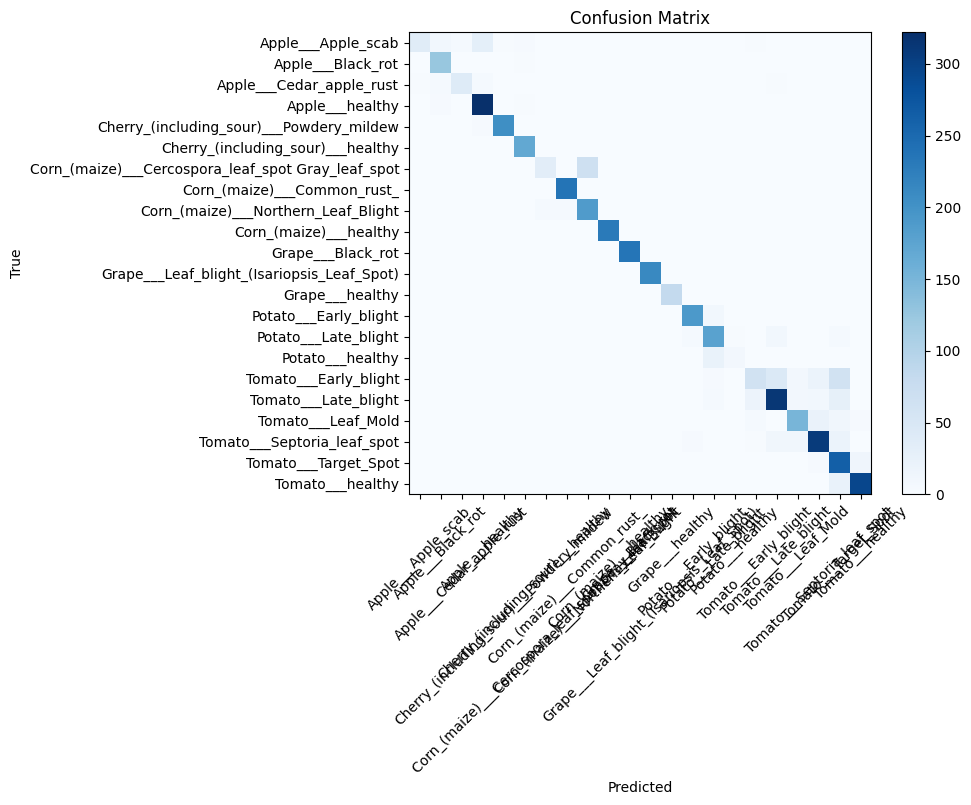

In [27]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [28]:
# Start TensorBoard in Colab
%load_ext tensorboard
%tensorboard --logdir ./logs


<IPython.core.display.Javascript object>

In [29]:
# Step 7: Function to test the model with input image
from tensorflow.keras.preprocessing import image

def test_single_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize

    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(image.load_img(image_path))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 19ms/step


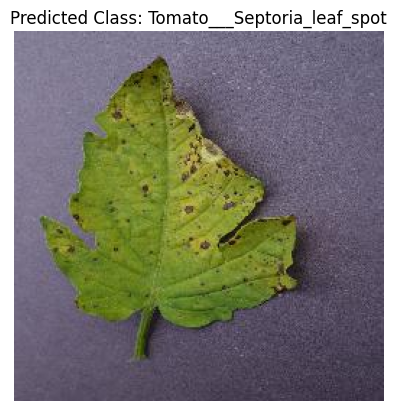

In [31]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Tomato___Septoria_leaf_spot/09dbdbad-6b02-45a8-a1d3-86cebfd1320d___Keller.St_CG 1799.JPG')

1/1 [==============================] - 0s 19ms/step


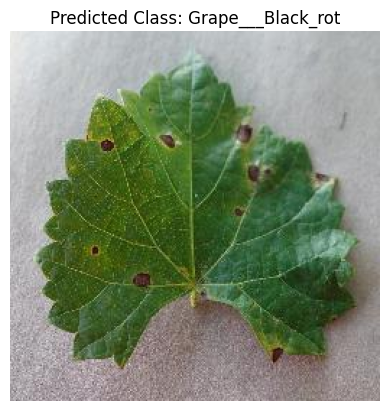

In [32]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Grape___Black_rot/1151f6a1-64a7-4f9b-84d4-39f1a22466bd___FAM_B.Rot 5028.JPG')

1/1 [==============================] - 0s 20ms/step


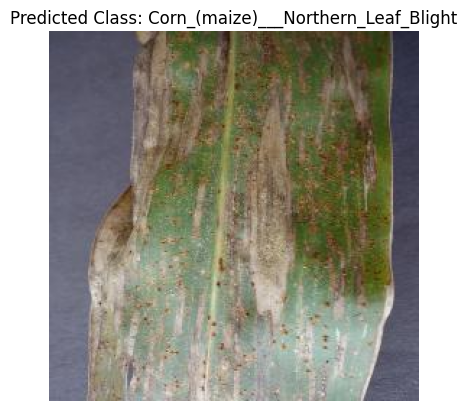

In [33]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Corn_(maize)___Northern_Leaf_Blight/a5ebf2d4-0bbc-4dda-9755-3519b14212e5___RS_NLB 3952.JPG')

1/1 [==============================] - 0s 43ms/step


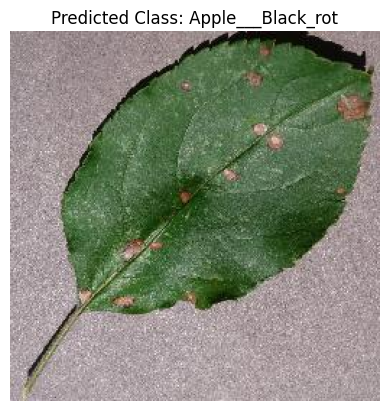

In [35]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Apple___Black_rot/9bae8265-90e1-4b34-8db3-35b530fded3d___JR_FrgE.S 8667.JPG')

1/1 [==============================] - 0s 19ms/step


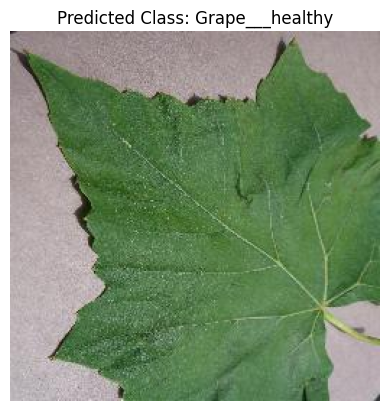

In [36]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Grape___healthy/8c5181ab-8b06-41a8-9b26-b3be052dcea1___Mt.N.V_HL 8905.JPG')